# Feature Selection - Stacking Ensembler
- This notebook will explore the **Stacking Ensemble** technique. Differernt base models and architectures will be tested looking for an optimal configuration. In this case, the Dataset with a feature-selection dimensionality reduction will be used.
- All data has been previously processed and normalized in the notebook `data_expl_and_preproc.ipynb`.

## Authors
- Izquierdo Alvarez, Mario
- Giménez López, Antonio
- Romero Romero, Martín
- Núñez Sánchez, Fernando

## Enviroment configuration
- Firstly, the needed packages along with our custom Modules are loaded. Additionally, a `Random.seed()` is set for reproducibility.

In [1]:
using Random
# Including Modules
push!(LOAD_PATH, "../modules")

#Random seed for reproducibility
seed=42
Random.seed!(seed)

TaskLocalRNG()

In [2]:
using HDF5
using Preprocessing
using ModelSelection
using Plotting
using Sk_Modeling

[ Info: Precompiling Sk_Modeling [top-level]
[ Info: Skipping precompilation since __precompile__(false). Importing Sk_Modeling [top-level].


## Loading data
- The dataset used in this notebook has been reduced using Feature Selection, using the correlation of the different features with the class as the selection criterion.

The selected features are:
1. RAM
2. Battery Power
3. Screen Height
4. Screen Width  

In [3]:
file = h5open("fs_data.h5", "r")
train_input = read(file, "train_input")
train_tags = read(file, "train_tags")
close(file)

In [4]:
# As the ensemble function handles different models, to work properly with all of them, the tags must be passed as a matrix of Ints

train_tags = map(x -> parse(Int,x), train_tags);

## 10-Fold Cross-Validation

The cross-validation technique is applied to get the performance estimation of the different models. 

In this process, we have tested several configurations trying to approximate an optimal one.

To face this problem, all base models that will be used (ANN, SVM, KNN and Decision Trees) have been tested previously in an individual manner. 

In general scenarios, Stacking is beneficed of the variability between the base models. Thus, we will test this stacking configurations with three base models, living one out. 

As an example, a first approach might be using **Decision Tree**, **SVM**, and **ANN** as the three base models, leaving out the **KNN**. All the base models will use the hyperparameter configuration that have previously demonstrated a major performance.

Finally, all the models will be joined together in a single stacking ensemble and it will be compared to the previous models.

In [5]:
model = :Stacking
# Params for cross validation
N = size(train_input, 1)
k = 10

kFoldIndices = crossvalidation(N,k);
best_models_acc = [];

In [6]:
# Defining the base models of the different staking models
estimators = [
    [:DecisionTree, :KNN, :SVM], # Leave out ANN
    [:DecisionTree, :KNN, :ANN], # Leave out SVM
    [:DecisionTree, :ANN, :SVM], # Leave out KNN
    [:ANN, :KNN, :SVM],          # Leave out DecisionTree
]
hyperparameters = [];

In [7]:

# Filling stacking 1 base models parameters
# The arquitectures with best individual results will be used as base models for this problem
stacking_1 = [
    Dict(:max_depth => 10, :criterion => "entropy", :random_state => seed), #tree params
    Dict(:n_neighbors => 15, :weights => "distance"), # KNN params
    Dict(:kernel => "linear", :C => 8.0, :random_state => seed) # SVM params
]

stacking_2 = [
    Dict(:max_depth => 10, :criterion => "entropy", :random_state => seed), #tree params
    Dict(:n_neighbors => 15, :weights => "distance"), # KNN params
    Dict(:hidden_layer_sizes => (128), :activation => "logistic", :learning_rate_init => 0.01, :validation_fraction => 0.2, 
        :n_iter_no_change => 80, :max_iter => 2000, :early_stopping => true, :random_state => seed), # ANN params
]

stacking_3 = [
    Dict(:max_depth => 10, :criterion => "entropy", :random_state => seed), #tree params
    Dict(:hidden_layer_sizes => (128), :activation => "logistic", :learning_rate_init => 0.01, :validation_fraction => 0.2, 
        :n_iter_no_change => 80, :max_iter => 2000, :early_stopping => true, :random_state => seed), # ANN params
    Dict(:kernel => "linear", :C => 8.0, :random_state => seed) # SVM params
]

stacking_4 = [
    Dict(:hidden_layer_sizes => (128), :activation => "logistic", :learning_rate_init => 0.01, :validation_fraction => 0.2, 
        :n_iter_no_change => 80, :max_iter => 2000, :early_stopping => true, :random_state => seed), # ANN params
    Dict(:n_neighbors => 15, :weights => "distance"), # KNN params
    Dict(:kernel => "linear", :C => 8, :random_state => seed) # SVM params
]

push!(hyperparameters, stacking_1);
push!(hyperparameters, stacking_2);
push!(hyperparameters, stacking_3);
push!(hyperparameters, stacking_4);

In [8]:
# Call the function to evaluate the model using different sets of hyperparameters and print the ranking of metrics.
all_metrics = evaluateAndPrintMetricsRanking(model, hyperparameters, train_input, train_tags, kFoldIndices, estimators);

# Saving the best acc result of the experiment
best_acc_result = (all_metrics[1][2]["acc"][1],all_metrics[1][2]["acc"][2])
push!(best_models_acc, best_acc_result); # Adding the best result to the list

Training with set of hyperparameters 1
Training with set of hyperparameters 2
Training with set of hyperparameters 3
Training with set of hyperparameters 4

----- acc means -----
Hyperparams set 1 -> 0.958 ± 0.016
Hyperparams set 3 -> 0.958 ± 0.016
Hyperparams set 4 -> 0.958 ± 0.016
Hyperparams set 2 -> 0.949 ± 0.019

----- sensitivity means -----
Hyperparams set 1 -> 0.958 ± 0.016
Hyperparams set 3 -> 0.958 ± 0.016
Hyperparams set 4 -> 0.958 ± 0.016
Hyperparams set 2 -> 0.949 ± 0.019

----- specificity means -----
Hyperparams set 1 -> 0.986 ± 0.005
Hyperparams set 3 -> 0.986 ± 0.005
Hyperparams set 4 -> 0.986 ± 0.005
Hyperparams set 2 -> 0.983 ± 0.006

----- ppv means -----
Hyperparams set 1 -> 0.96 ± 0.015
Hyperparams set 3 -> 0.96 ± 0.015
Hyperparams set 4 -> 0.96 ± 0.015
Hyperparams set 2 -> 0.952 ± 0.018

----- npv means -----
Hyperparams set 1 -> 0.985 ± 0.006
Hyperparams set 3 -> 0.985 ± 0.006
Hyperparams set 4 -> 0.985 ± 0.006
Hyperparams set 2 -> 0.982 ± 0.007

----- f_score m

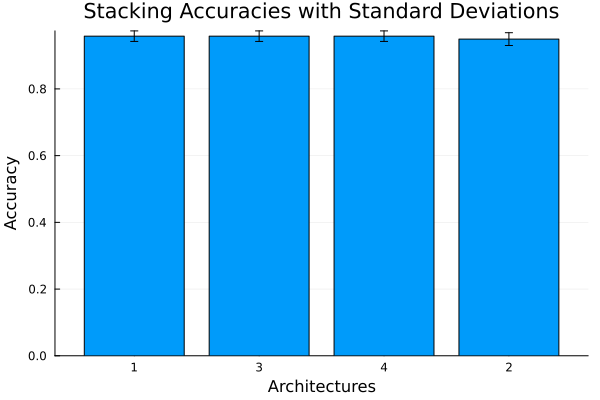

In [9]:
plot_acc_comparison(model, all_metrics)

### Discussion

Note that in this notebook, for the stacking technique, it has been used Flux to implement ANN models, so the MLPClassifier has not been evaluated for separately. This allows for the exploration of additional configurations; in this case, we will test the inclusion of an adaptive learning rate. The introduction of an adaptive learning rate could potentially improve the model's ability to fine-tune its learning process, adjusting the rate based on the model's performance and progression, which might lead to better overall ensemble model performance.


Analyzing the results, all the resuls are similar and it demonstrate that stacking ensemble techniques are well-performing when facing this problem. Tt can be seen that the worst model is the one which excludes SVM, as we were expecting. 

In addition to the adaptive learning rate, it also will be tested a stacking ensembler with its base models simplified, with the complexity of its hyperparameters severaly reduced.


In [10]:
estimators = [
    [:DecisionTree, :ANN, :SVM, :KNN], # All in
    [:DecisionTree, :ANN, :SVM, :KNN] # All in simple models
]
hyperparameters = [];

# Filling stacking 1 base models parameters
# The arquitectures with best individual results will be used as base models for this problem

stacking_1 = [
    Dict(:max_depth => 10, :criterion => "entropy", :random_state => seed), #tree params
    Dict(:hidden_layer_sizes => (128), :activation => "logistic", :learning_rate_init => 0.01, :validation_fraction => 0.2, 
        :n_iter_no_change => 80, :max_iter => 2000, :early_stopping => true, :random_state => seed, :learning_rate => "adaptive"), # ANN params
    Dict(:kernel => "linear", :C => 8.0, :random_state => seed), # SVM params
    Dict(:n_neighbors => 15, :weights => "distance") # KNN params
]
stacking_2 = [
    Dict(:max_depth => 5, :criterion => "entropy", :random_state => seed), #tree params
    Dict(:hidden_layer_sizes => (32,), :activation => "logistic", :learning_rate_init => 0.01, :validation_fraction => 0.2, 
        :n_iter_no_change => 20, :max_iter => 1000, :early_stopping => true, :random_state => seed), # ANN params
    Dict(:kernel => "linear", :C => 4.0, :random_state => seed), # SVM params
    Dict(:n_neighbors => 7, :weights => "uniform") # KNN params
]

push!(hyperparameters, stacking_1);
push!(hyperparameters, stacking_2);

all_metrics = evaluateAndPrintMetricsRanking(model, hyperparameters, train_input, train_tags, kFoldIndices, estimators);

# Saving the best acc result of the experiment
best_acc_result = (all_metrics[1][2]["acc"][1],all_metrics[1][2]["acc"][2])
push!(best_models_acc, best_acc_result); # Adding the best result to the list

Training with set of hyperparameters 1
Training with set of hyperparameters 2

----- acc means -----
Hyperparams set 1 -> 0.958 ± 0.016
Hyperparams set 2 -> 0.956 ± 0.015

----- sensitivity means -----
Hyperparams set 1 -> 0.958 ± 0.016
Hyperparams set 2 -> 0.956 ± 0.015

----- specificity means -----
Hyperparams set 1 -> 0.986 ± 0.005
Hyperparams set 2 -> 0.986 ± 0.005

----- ppv means -----
Hyperparams set 1 -> 0.96 ± 0.015
Hyperparams set 2 -> 0.958 ± 0.014

----- npv means -----
Hyperparams set 1 -> 0.985 ± 0.006
Hyperparams set 2 -> 0.984 ± 0.006

----- f_score means -----
Hyperparams set 1 -> 0.958 ± 0.016
Hyperparams set 2 -> 0.956 ± 0.015

----- err_rate -----
Hyperparams set 1 -> 0.042 ± 0.016
Hyperparams set 2 -> 0.044 ± 0.015


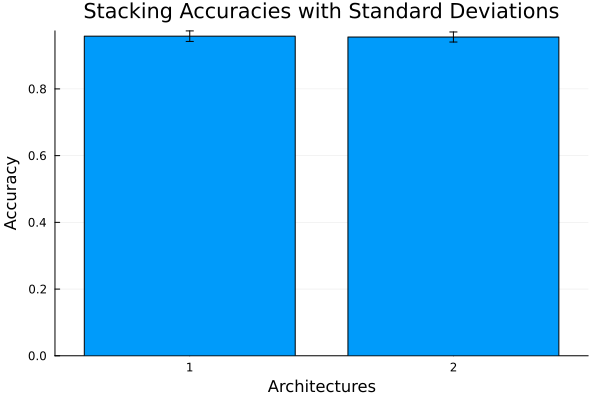

In [11]:
plot_acc_comparison(model, all_metrics)

### Discussion
It is observed that while neither of these models has been the best in terms of accuracy, both yield very good results. Furthermore, it is noteworthy that the second model, which utilizes notably simpler base models, offers a similar performance to the best model obtained. This demonstrates the significant potential of ensemble methods.

The success of the simpler model in particular highlights how ensemble techniques can leverage the strengths of individual, even basic, models to achieve robust overall performance.



## Final discussion

Finally, it is difficult to choose one of the trained models beacuse almost all of them have achieved the same results in all the metrics. In this situation, we will select the model with the 3 based models that have presented the best individual performance

1. **Decision Tree**
2. **Artificial neural network**
3. **Support Vector Machine**

This results in an **accuracy** of **0.958 ± 0.016**. Once again, It is also remarkable the high performance of the ensemble with simple base models. It's noteworthy that using this sort of ensemble might be better, since the computational complexity can be significantly lower while risking very little in terms of accuracy. 